
> **ISO2024 INTRODUCTORY SPATIAL 'OMICS ANALYSIS**
>
>
>- HYBRID : TORONTO & ZOOM
>- 9TH JULY 2024 <br>

>**Module 3 : Building your spatial model** ** PART I ** <BR>
>
>**Instructor : Shamini Ayyadhury**
>
---

> TOPICS COVERED

* A. Normalizing your data *
* B. Spatial and non-spatial clustering *

***

`
A. NORMALIZATION AND DIMENSIONAL REDUCTION
`

In [1]:
### import the following libraries. Some of these were used in the previous notebook and we are using them here as well
import sys # system specific parameters and functions
import os # operating system dependent functionality

import pandas as pd # data manipulation and analysis

import matplotlib.pyplot as plt # plotting library
import seaborn as sns # data visualization library based on matplotlib

import scanpy as sc # single-cell analysis in Python
#from PIL import Image # Python Imaging Library

sys.path.append('/home/shamini/data/projects/spatial_workshop/')
import pre_processing_fnc as ppf # import memory usage function only


In [41]:
### directory & filepaths

data_dir = '/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/'
out = '/home/shamini/data/projects/spatial_workshop/out/'

os.makedirs(out+'module3/figures/', exist_ok=True) # create a new directory to store the output files
os.makedirs(out+'module3/objects/', exist_ok=True) # create a new directory to store the output files

In [42]:
### IMPORT DATA

'''
1. ANNDATA OBJECT FROM MODULE 2
2. A PREVIOUSLY ANNOTATED CELL LABEL FOR THE MICE BRAIN - DERIVED FROM THE ALLEND BRAIN ATLAS
    *** students can look at supplementary script 01 to see how the cell label was processed
'''

adata = sc.read_h5ad(out+'module2/objects/adata.h5ad')
print(adata)

cell_label = pd.read_csv('/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/obj.csv', index_col=0)
cell_label = cell_label['predicted.id']
print(cell_label)

ppf.get_memory_usage()

AnnData object with n_obs × n_vars = 60829 × 347
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_genes'
    var: 'n_cells'
    uns: 'n_genes_mean', 'n_genes_med', 'spatial'
    obsm: 'spatial'
aaabiggh-1         Astro
aaacfoel-1         Astro
aaaeefil-1         Astro
aaaehidd-1    Macrophage
aaagcbkg-1         Astro
                 ...    
oindmjog-1          VLMC
oinecaba-1          VLMC
oinehfmf-1          VLMC
oinemiil-1          VLMC
oingfoec-1            L4
Name: predicted.id, Length: 60099, dtype: object


'Memory usage: 2574.49 MB'

In [7]:
'''
ATTACH CELL LABELS TO THE ANNDATA OBJECT, BY CONCATENATING WITH THE OBSERVATION DATAFRAME
The number of cells labelled was missing slightly under 1000 cells, so we will drop the cells and their corresponding data from the anndata object
'''

# Subset adata to include only the cells present in cell_label
common_indices = adata.obs.index.intersection(cell_label.index)
adata = adata[common_indices].copy()

# Reindex cell_label to match adata_subset
cell_label_subset = cell_label.reindex(adata.obs.index)
adata.obs['cell_label'] = cell_label_subset

# Print results
print("\nSubset AnnData object created successfully!")
print(adata)

ppf.get_memory_usage()



Subset AnnData object created successfully!
AnnData object with n_obs × n_vars = 60099 × 347
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_genes', 'cell_label'
    var: 'n_cells'
    uns: 'n_genes_mean', 'n_genes_med', 'spatial'
    obsm: 'spatial'


'Memory usage: 1450.75 MB'

NORMALIZATION & DIMENSIONAL REDUCTION - BASIC STEPS 
1. We will will go through the primary steps of normalization - to keep the flow of the methods intact.
2. We will using 2 normalization methods 
    * Standard size factor normalization & lop1p transformation
    * Pearson residuals 
3. We will have a short discussion on the need for developmental in normalization and dimensional reduction methods before moving onto clustering 

In [8]:
#adata.layers['deseq2'] = dds.X.copy()
import numpy as np

adata.X = adata.raw.X.copy()

# 1. Pearson residual normalization
### perform the pearson residual transformation
adata.X = adata.raw.X.copy() ### reset the adata.X to the raw data
sc.experimental.pp.normalize_pearson_residuals(adata) ### perform the pearson residual transformation
adata.layers['pearson_residual'] = adata.X.copy() ### save the normalized and transformed adata.X in the layer

sc.pp.pca(adata, n_comps=9, svd_solver='arpack') ### perform PCA
adata.obsm['pearsonPCA'] = adata.obsm['X_pca'].copy() ### save the X_PCA coordinates to another layer labeled pearsonPCA

sc.pp.neighbors(adata, n_pcs=9, n_neighbors=15) ### find the neighbors
adata.uns['pearson_neigh'] = adata.uns['neighbors'] ### save the neighbors in another layer

sc.tl.umap(adata, neighbors_key='pearson_neigh', min_dist=0.1, spread=1.0, method='umap', init_pos='spectral') ### perform UMAP
adata.obsm['pearsonUMAP'] = adata.obsm['X_umap'].copy() ### save the UMAP coordinates to another layer labeled pearsonUMAP


# 2. Standard normalization
### now perform the standard normalization and transformation
adata.X = adata.raw.X.copy() ### reset the adata.X to the raw data
sc.pp.normalize_total(adata, target_sum=1e4) ### set the size factor to 1e4

sc.pp.log1p(adata) ### perform the log1p transformation
adata.layers['log1p_scaled'] = adata.X.copy() ### save the normalized and transformed adata.X in the layer

sc.pp.pca(adata, n_comps=9, svd_solver='arpack') ### perform PCA
adata.obsm['stdPCA'] = adata.obsm['X_pca'].copy() ### save the X_PCA coordinates to another layer labeled stdPCA

sc.pp.neighbors(adata, n_pcs=9, n_neighbors=15) ### find the neighbors
adata.uns['std_neigh'] = adata.uns['neighbors'] ### save the neighbors in another layer

sc.tl.umap(adata, neighbors_key='std_neigh', min_dist=0.1, spread=1.0, method='umap', init_pos='spectral') ### perform UMAP
adata.obsm['stdUMAP'] = adata.obsm['X_umap'].copy() ### save the UMAP coordinates to another layer labeled stdUMAP

#sc.tl.leiden(adata, resolution=0.3, key_added='std_leiden_0.3')


ppf.get_memory_usage() ### monitor memory usage

/home/shamini/anaconda3/envs/xenium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Memory usage: 1714.68 MB'

<Axes: title={'center': 'Pearson normalization'}, xlabel='pearsonUMAP1', ylabel='pearsonUMAP2'>

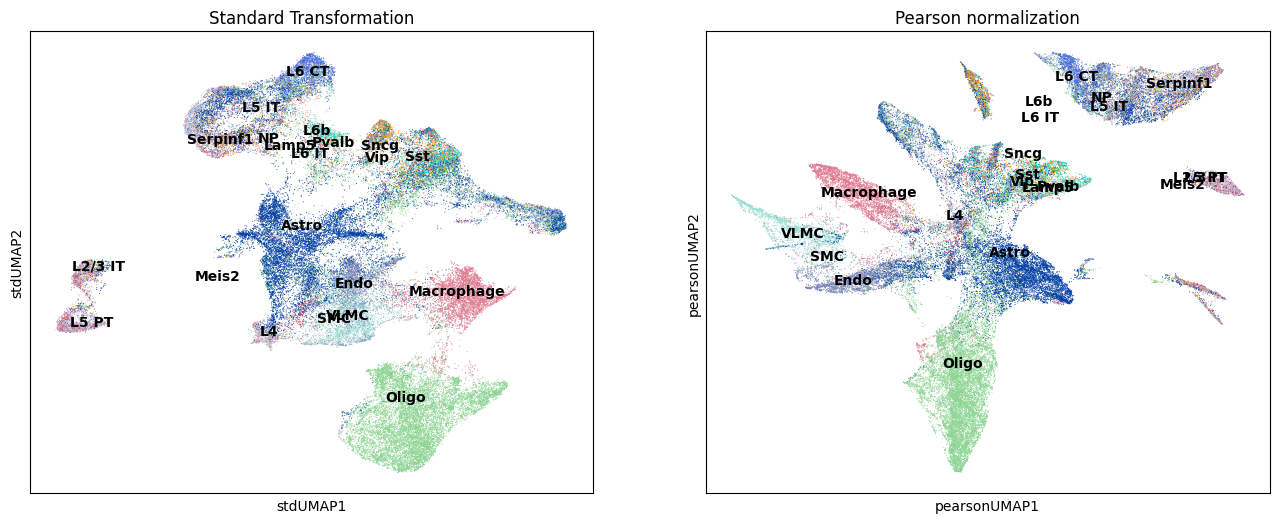

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

sc.pl.embedding(adata, basis='stdUMAP', 
                color='cell_label', 
                title='Standard Transformation', 
                legend_loc='on data', 
                ax=axes[0], 
                show=False)

sc.pl.embedding(adata, 
                basis='pearsonUMAP', 
                color='cell_label', 
                title='Pearson normalization', 
                legend_loc='on data', 
                ax=axes[1], 
                show=False)

plt.savefig(out+'module3/figures/figure01_standard_vs_pearson.png', dpi=300)

PLOTTING THE ABOVE OUTPUT 

---
PRACTICE ON YOUR OWN :

Perform two other normalization methods on your own
1. Freeman-Turkey Normalization <ref>

2. Changing the size factor for the log normalization


> QUESTIONS TO PONDER & DEBATE UPON <BR>
*NORMALIZATION*
> 1. ARE CURRENT METHODS FOR NORMALIZING SINGLE CELL DATASETS RELEVENT FOR SPATIAL DATA NORMALIZATION?
> 2. WHAT ARE THE DIFFERENCES BETWEEN DROPLET/PLATE BASED SINGLE CELL SYSTEMS AND SINGLE MOLECULE IMAGING BASED SYSTEMS AND HOW DO YOU 
THINK THESE AFFECT THE COUNTS MODEL DISTRIBUTION AND SUBSEQUENT NORMALIATION METHODS?
> 3. WHAT ASPECTS OF SPATIAL MODELING COULD INFLUENCE THE DEVELOPMENT OF NOVEL NORMALIZATION METHODS FOR SPATIAL TECHNOLOGIES?

> *DIM REDUCTION METHODS*
> 1. WE ARE USING THE SCANPY PACKAGE DERIVED UMAP, PCA , NEAREST NEIGHBOURHOOD CALCULATION FOR UMAP AND LEIDEN. ARE THE PARAMTERS STILL VALID FOR AND OPTIMAL FOR SINGLE MOLECULE IMAGING PLATFORMS LIKE THE XENIUM, MERSCOPE ?
> 2. WHAT WOULD GIVE BETTER FLEXIBILITY IN EFFECTIVELY REDUCING DIMENSIONS AND IN IMPROVING EFFICIENCY?
>    * PARTICIPANTS ARE ENCOURAGED TO TRY OUT THESE ALTERNATIVE PACKAGES WHICH GIVES MORE FLEXIBILITY IN PARAMTER TUNING AND TO USE MACHINE LEARNING MODELING TO SPEED PROCESSING AS SINGLE MOLECULE SPATIAL DATASETS ARE MANIFOLD LARGER THAN SINGLE CELL DATASETS
---

In [19]:


# 3. Median size factor normalization
### now perform the standard normalization and transformation

'''
FILL IN THE BLANKS
'''
adata.X = adata.raw.X.copy() ### reset the adata.X to the raw data
median = np.median(adata.X.sum(axis=1)) ### calculate the median of the sum of the adata.X

scale_factors = median / adata.X.sum(axis=1) ### calculate the scale factors
adata.X = adata.X * (scale_factors[:, np.newaxis])  ### multiply the adata.X by the scale factors

sc.pp.log1p(adata) ### perform the log1p transformation
adata.layers['log1p_med'] = adata.X.copy() ### save the normalized and transformed adata.X in the layer

sc.pp.pca(adata, n_comps=9, svd_solver='arpack') ### perform PCA
adata.obsm['areaPCA'] = adata.obsm['X_pca'].copy() ### save the X_PCA coordinates to another layer labeled stdPCA

sc.pp.neighbors(adata, n_pcs=9, n_neighbors=27) ### find the neighbors
adata.uns['area_neigh'] = adata.uns['neighbors'] ### save the neighbors in another layer

sc.tl.umap(adata, neighbors_key='med_neigh', min_dist=0.1, spread=1.0, method='umap', init_pos='spectral') ### perform UMAP
adata.obsm['areaUMAP'] = adata.obsm['X_umap'].copy() ### save the UMAP coordinates to another layer labeled stdUMAP

#sc.tl.leiden(adata, resolution=0.3, key_added='std_leiden_0.3')


'Memory usage: 2149.91 MB'

In [ ]:

# 4. Freeman Tukey transformation 
adata.X = adata.raw.X.copy() ### reset the adata.X to the raw data

'''
FILL IN THE BLANKS
'''
### use numpy to perform the freeman tukey transformation
adata.X = np.sqrt(adata.X) + np.sqrt(adata.X+1) ### perform the freeman tukey transformation
adata.layers['freemanTukey'] = adata.X  ### save the normalized and transformed adata.X in the layer

'''
FILL IN THE BLANKS
'''
sc.pp.pca(adata, n_comps=9, svd_solver='arpack') ### perform PCA
adata.obsm['freemanPCA'] = adata.obsm['X_pca'].copy() ### save the X_PCA coordinates to another layer labeled freemanPCA

'''
FILL IN THE BLANKS
'''
sc.pp.neighbors(adata, n_pcs=9, n_neighbors=27) ### find the neighbors
adata.uns['freeman_neigh'] = adata.uns['neighbors'] ### save the neighbors in another layer
sc.tl.umap(adata, neighbors_key='freeman_neigh', min_dist=0.1, spread=1.0, method='umap', init_pos='spectral') ### perform UMAP
adata.obsm['freemanUMAP'] = adata.obsm['X_umap'].copy() ### save the UMAP coordinates to another layer labeled freemanUMAP


ppf.get_memory_usage() ### monitor memory usage

---
> Lets stop to discuss.
>   * Which normalization method is the best? 

<Axes: title={'center': 'Freeman Tukey Transformation'}, xlabel='freemanUMAP1', ylabel='freemanUMAP2'>

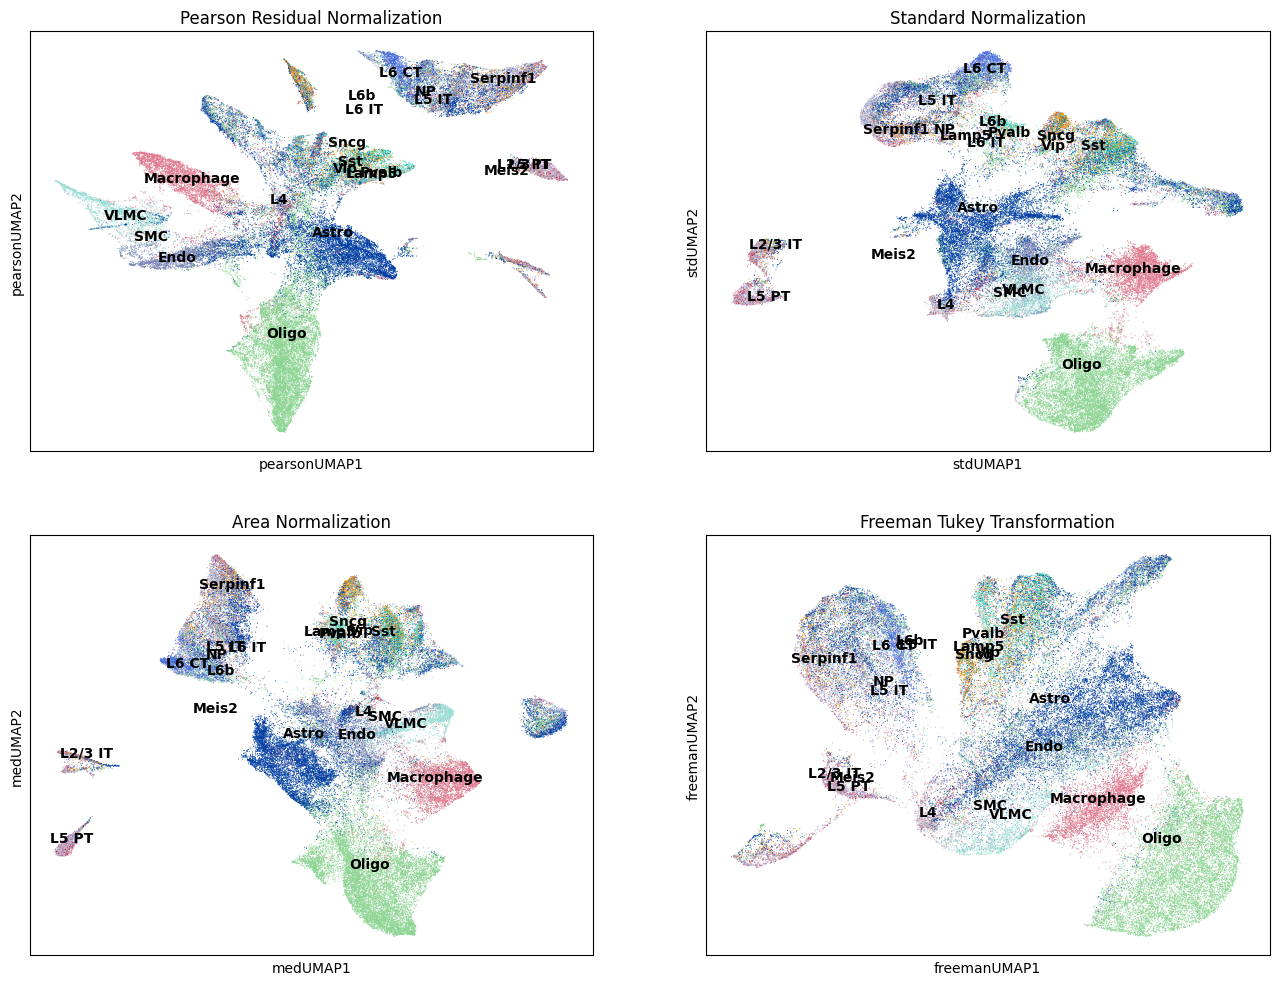

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

sc.pl.embedding(adata, basis='pearsonUMAP', 
                color='cell_label', 
                title='Pearson Residual Normalization', 
                legend_loc='on data', 
                ax=axes[0], 
                show=False)

sc.pl.embedding(adata, 
                basis='stdUMAP', 
                color='cell_label', 
                title='Standard Normalization', 
                legend_loc='on data', 
                ax=axes[1], 
                show=False)

sc.pl.embedding(adata, 
                basis='medUMAP', 
                color='cell_label', 
                title='Median Normalization', 
                legend_loc='on data', 
                ax=axes[2], 
                show=False)

sc.pl.embedding(adata, 
                basis='freemanUMAP', 
                color='cell_label', 
                title='Freeman Tukey Transformation', 
                legend_loc='on data', 
                ax=axes[3], 
                show=False)

plt.savefig(out+'module3/figures/figure02_normalization_transformations_4methods.png', dpi=300)

In [34]:
# 3. Freeman Tukey transformation 

'''
FILL IN THE BLANKS
'''
### use numpy to perform the freeman tukey transformation

adata.X = adata.raw.X.copy() ### reset the adata.X to the raw data
median = np.median(adata.X.sum(axis=1)) ### calculate the median of the sum of the adata.X

scale_factors = median / adata.X.sum(axis=1) ### calculate the scale factors
adata.X = adata.X * (scale_factors[:, np.newaxis])  ### multiply the adata.X by the scale factors

adata.X = np.sqrt(adata.X) + np.sqrt(adata.X+1) ### perform the freeman tukey transformation
adata.layers['freemanTukey_medN'] = adata.X  ### save the normalized and transformed adata.X in the layer

'''
FILL IN THE BLANKS
'''
sc.pp.pca(adata, n_comps=9, svd_solver='arpack') ### perform PCA
adata.obsm['freeman_medN_PCA'] = adata.obsm['X_pca'].copy() ### save the X_PCA coordinates to another layer labeled freemanPCA

'''
FILL IN THE BLANKS
'''
sc.pp.neighbors(adata, n_pcs=9, n_neighbors=27) ### find the neighbors
adata.uns['freeman_medN_neigh'] = adata.uns['neighbors'] ### save the neighbors in another layer
sc.tl.umap(adata, neighbors_key='freeman_medN_neigh', min_dist=0.1, spread=1.0, method='umap', init_pos='spectral') ### perform UMAP
adata.obsm['freeman_medN_UMAP'] = adata.obsm['X_umap'].copy() ### save the UMAP coordinates to another layer labeled freemanUMAP


<Axes: title={'center': 'med size factor normalization followed by Freeman Tukey Transformation'}, xlabel='freeman_medN_UMAP1', ylabel='freeman_medN_UMAP2'>

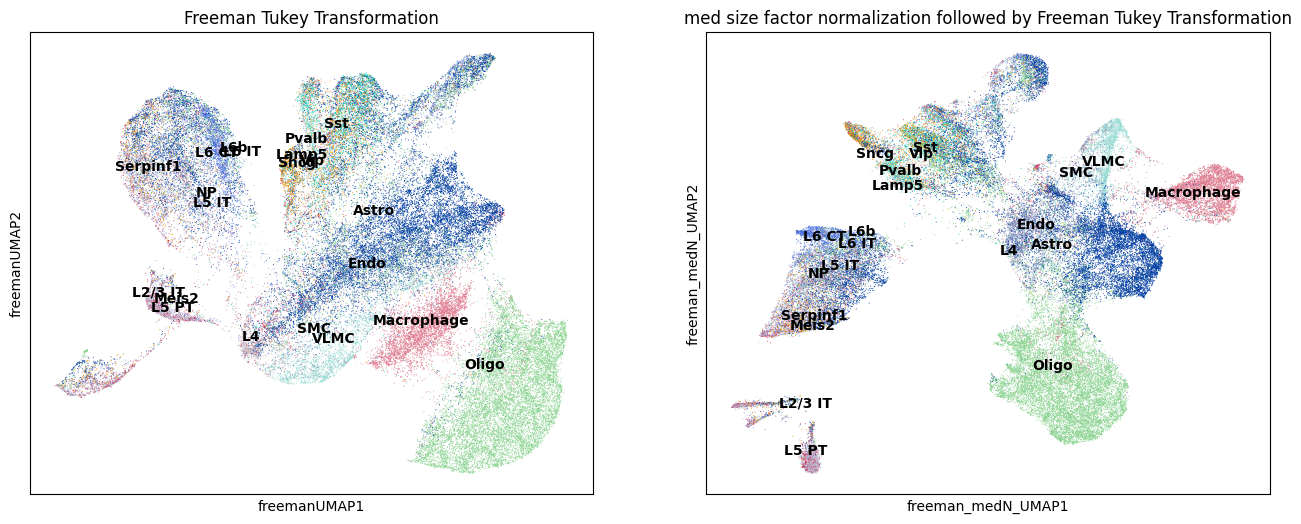

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sc.pl.embedding(adata, 
                basis='freemanUMAP', 
                color='cell_label', 
                title='Freeman Tukey Transformation', 
                legend_loc='on data', 
                ax=axes[0], 
                show=False)

sc.pl.embedding(adata, 
                basis='freeman_medN_UMAP', 
                color='cell_label', 
                title='med size factor normalization followed by Freeman Tukey Transformation', 
                legend_loc='on data', 
                ax=axes[1], 
                show=False)

plt.savefig(out+'module3/figures/figure03_freeman_tukey_medN_with_wo_scaling.png', dpi=300)

In [43]:
adata.write_h5ad(out+'module3/objects/adata.h5ad') ### save the anndata object

> END OF MODULE 3 : NORMALIZATION, DIMENSIONAL REDUCTION <br>
> Thank you and see you in the next lecture where we will tackle spatial clustering